# Correlation analysis

## 0) import libraries

In [13]:
import json
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../Multilevel/'))
import helpers
import utils_MEM
from paths import RESULTS_DIR_EDA, TRIALS_PATH

In [14]:
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 300

mpl.rcParams['font.size'] = 20
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

## 1) import data 
set unique index to 
- ID
- AREA (1: most painful, 2: control, 3: ad)
- B (number of experiment either 1 or 2) 
- iTrials (unique vaue for each trial in each experiment B)

In [15]:
filename = "../Classification/args_class.json"
with open(filename) as f:
    args = json.load(f)
TrialsFeatures = helpers.read_dataset(TRIALS_PATH)
TrialsFeatures.set_index([TrialsFeatures["id"], TrialsFeatures["Area"],TrialsFeatures["B"],TrialsFeatures["iTrial"]], inplace=True)

In [16]:
trials=TrialsFeatures.fillna(0)

## Correlation analysis

### 2.1) trial-specific

In [17]:
#trials=trials.join(pd.get_dummies(trials.AreaName))
HC=True
##if we want only patients and not healthy controls
if not HC:
    trials=trials[trials.cohort_HC==0]
signals=["SCH", "SCF", "EEG"]
col_to_keep=[col for col in trials.columns if any(sig in col for sig in signals)]
trials_=trials[col_to_keep]

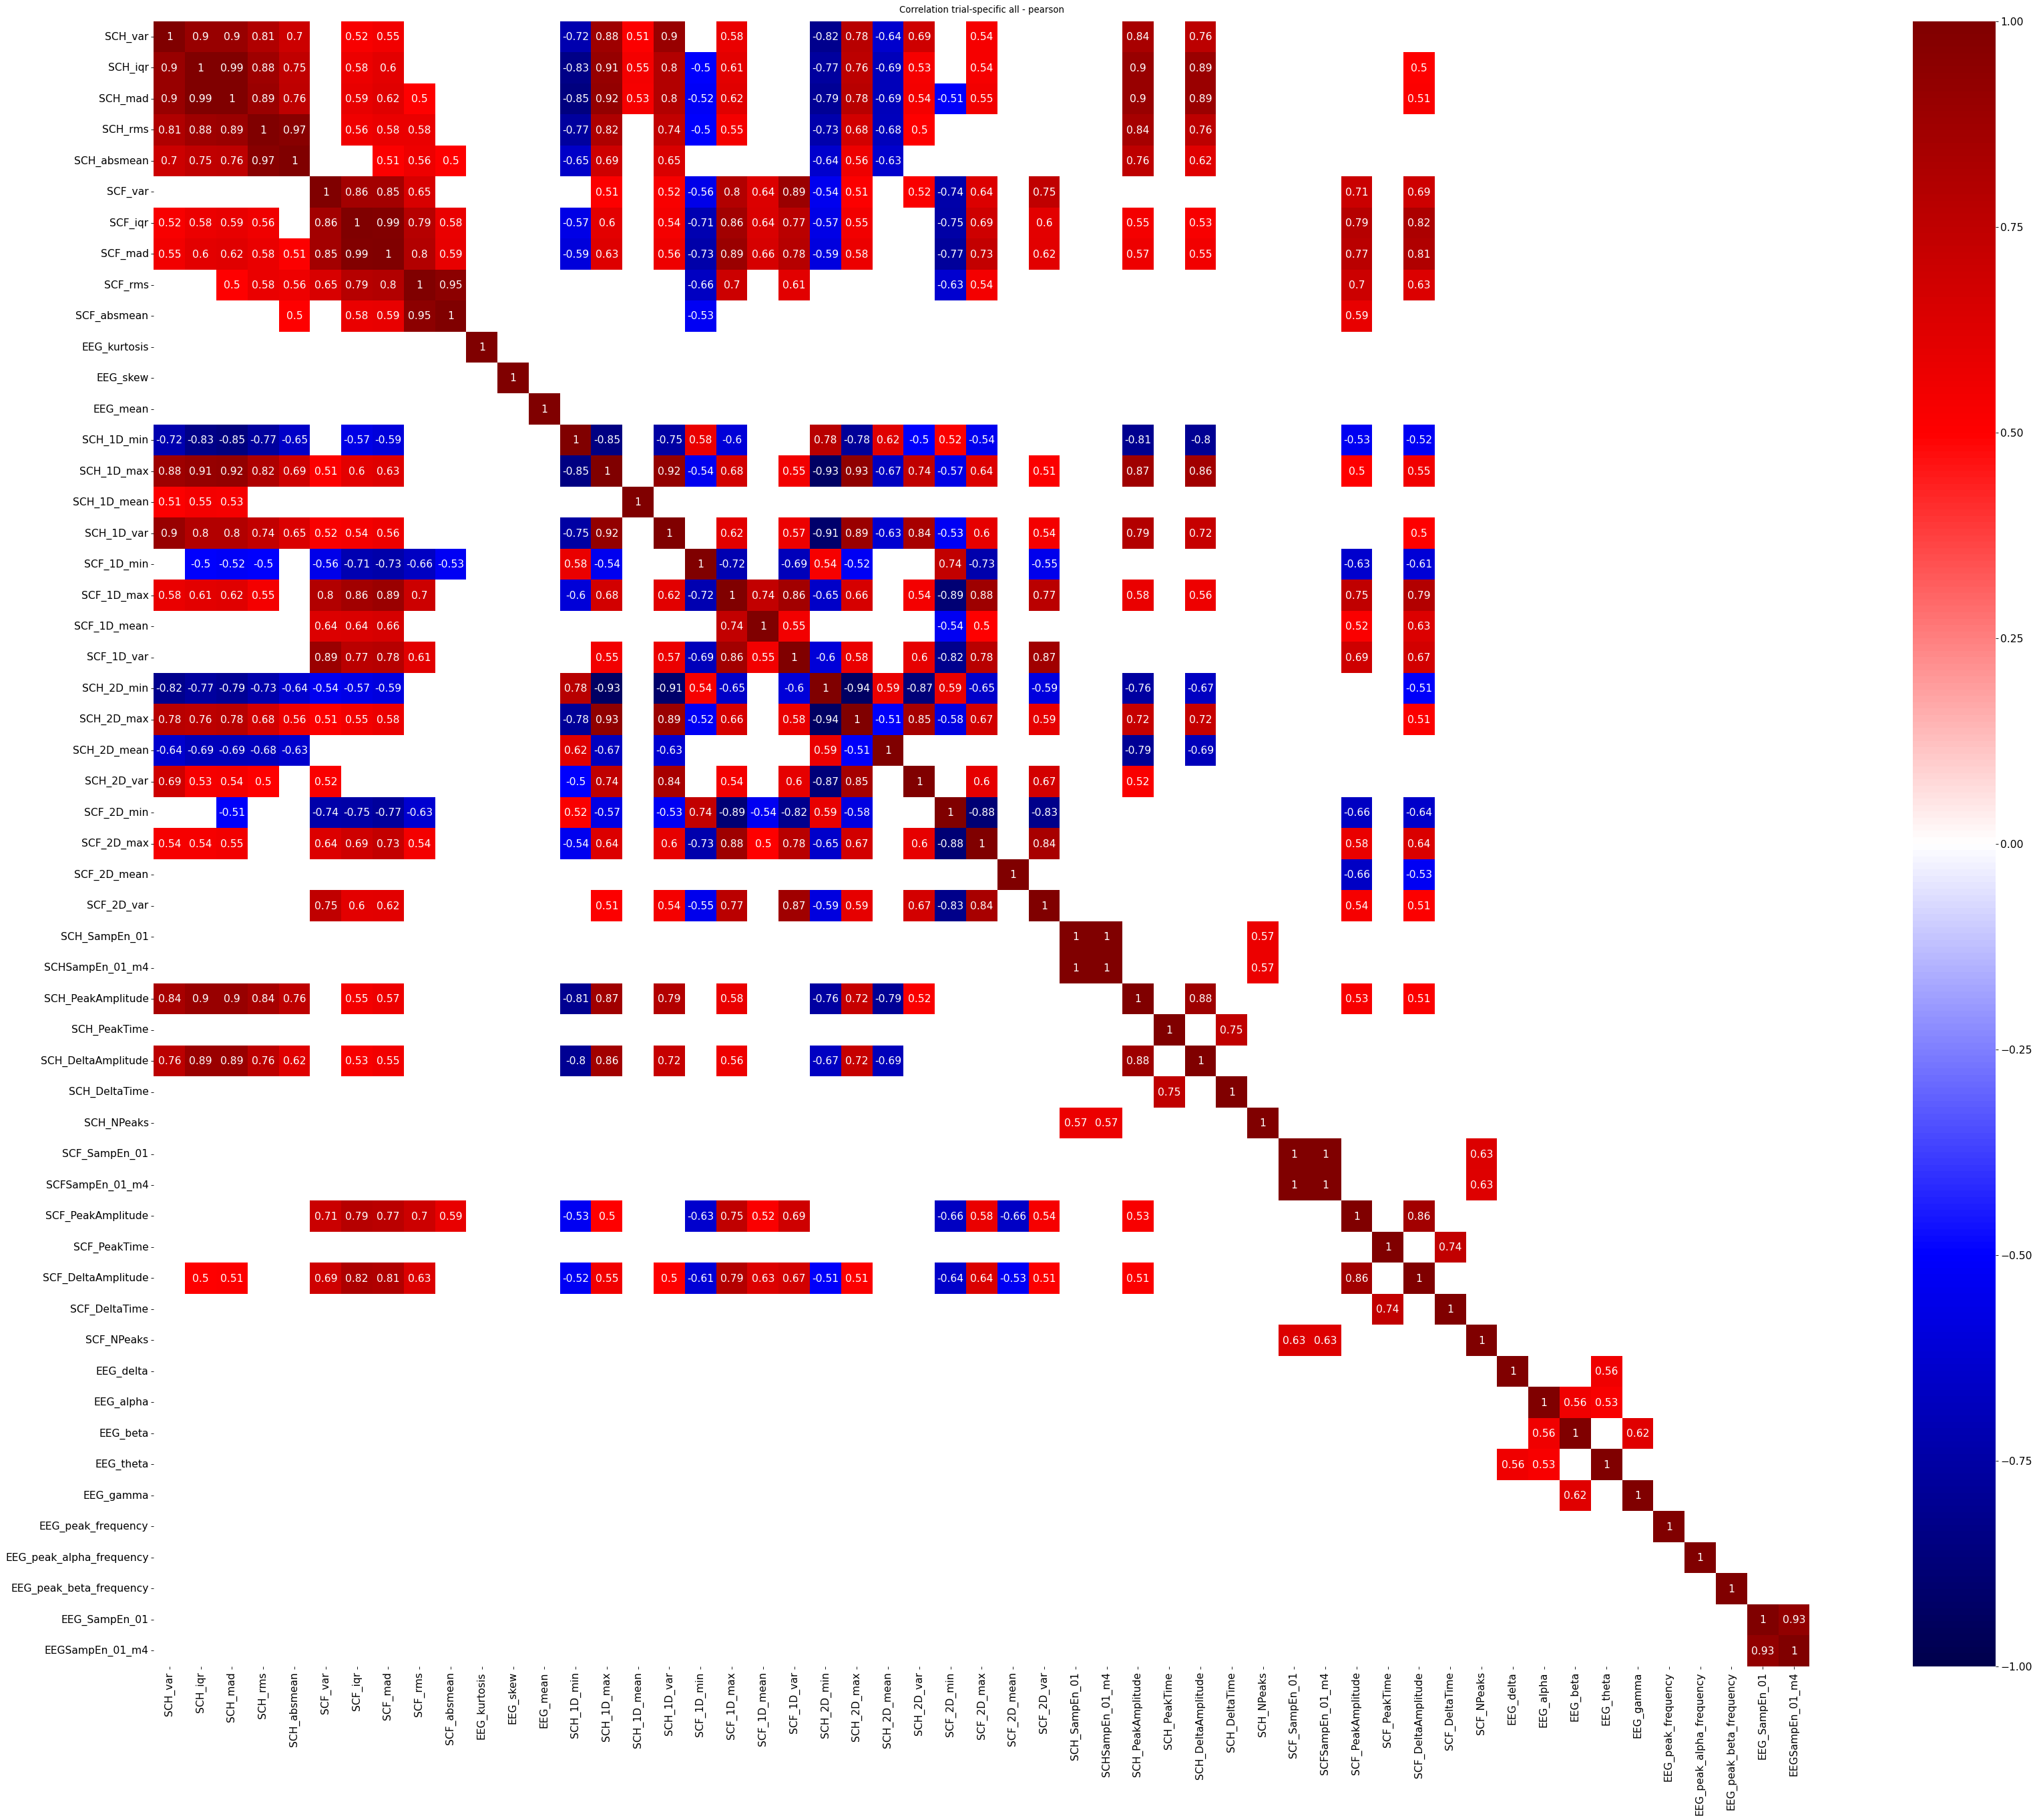

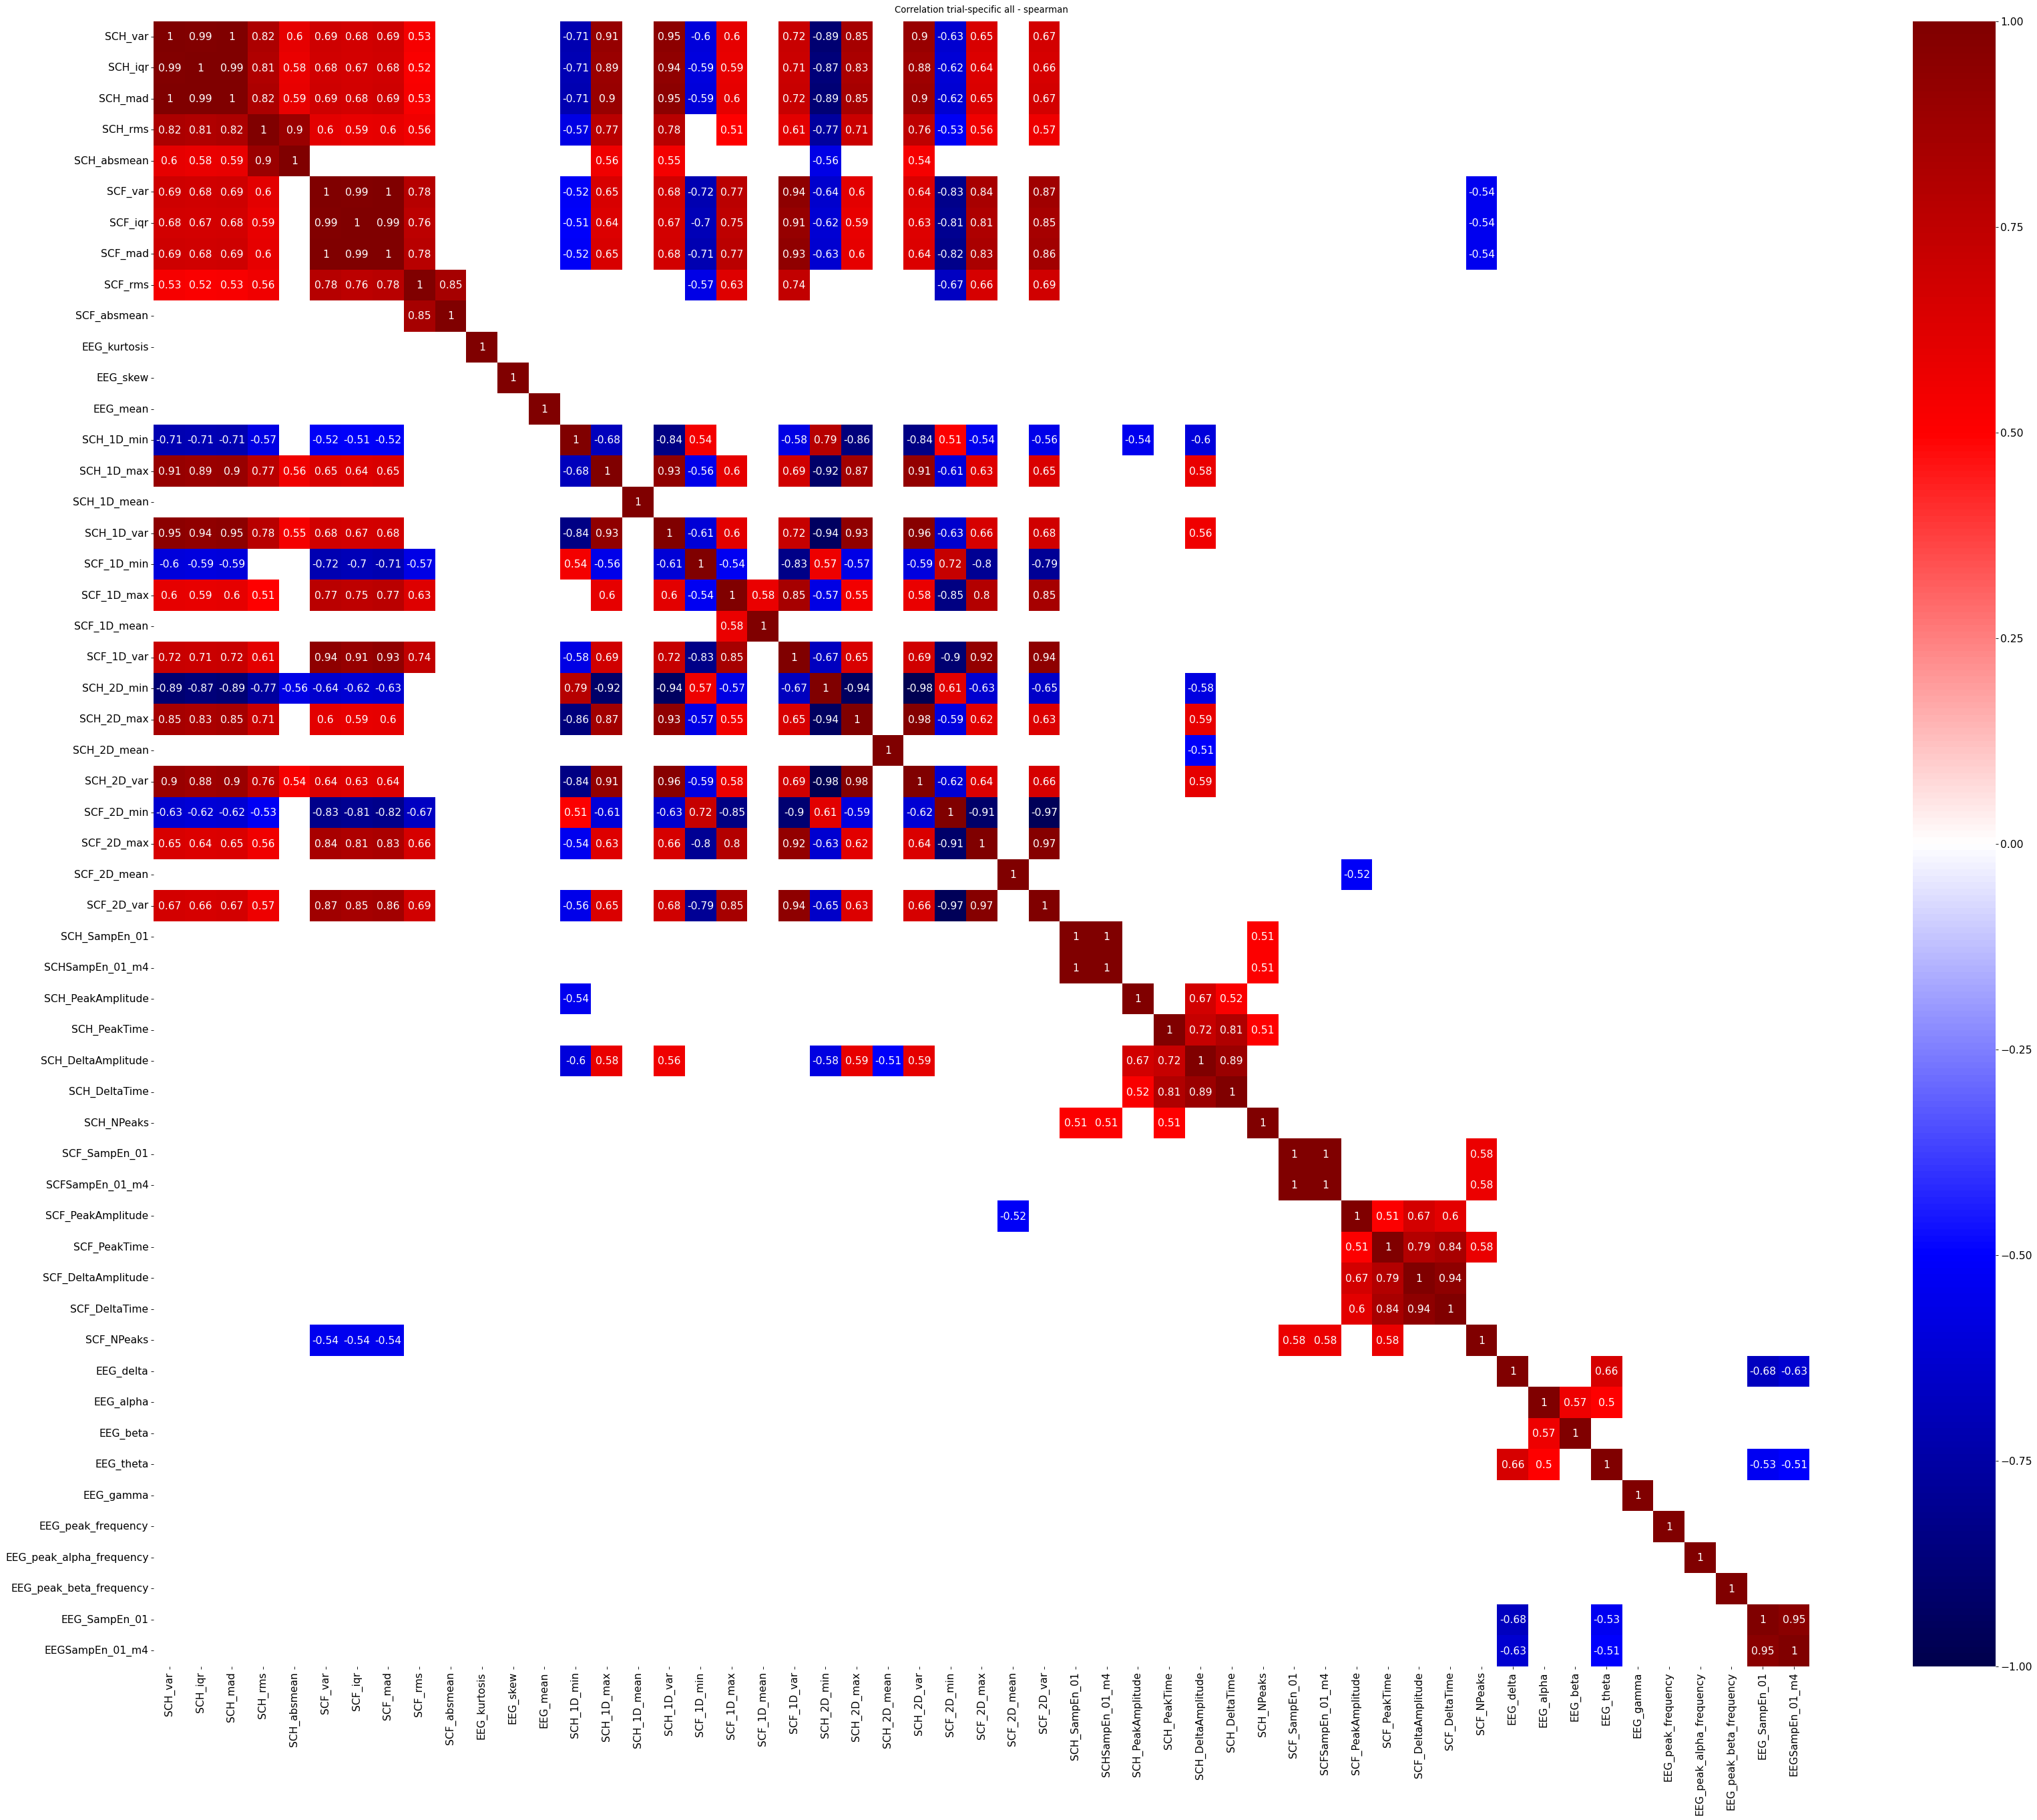

In [18]:
save=False
mpl.rcParams['font.size'] = 14
trials_= trials_.loc[:, (trials_ != 0).any(axis=0)]
for corr_method in ["pearson", "spearman"]:
    plt.figure(figsize=(50,40))
    corr=trials_.corr(method=corr_method)
    matrix = np.triu(trials_.corr(method=corr_method))
    mask=(corr>=0.5) | (corr <=-0.5)
    #heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="seismic")
    heatmap = sns.heatmap(corr[mask], vmin=-1, vmax=1, annot=True, cmap="seismic")
    heatmap.set_title('Correlation trial-specific all - '+corr_method, fontdict={'fontsize':12}, pad=12)
    if save:
        plt.savefig(RESULTS_DIR_EDA + "Correlation/trial-specific all mask - "+corr_method)

### 2.1) subject-specific features

In [19]:
column_patterns_to_remove = ['_AllQuestions', 'rand_', 'PeaksP_', 'PeaksN_', 'height',
                             '_PreExperiment', '_PostExperiment', '_Before',
                             'Location_']  # , 'cohort_'
other_columns_to_remove = ['cohort_HC', 'room_temp_v1', 'room_temp_v2', 'woman_cycle_v1', 'woman_cycle_v2',
                           'time_v1', 'time_v2']


trials_subj=utils_MEM.create_subj_dataset(area="mp", columns_to_remove=column_patterns_to_remove+other_columns_to_remove, fill_na=False, cohort_path="datasets\\")

HC=True
##if we want only patients and not healthy controls
if not HC:
    trials_subj=trials_subj[trials_subj.cohort_HC==0]

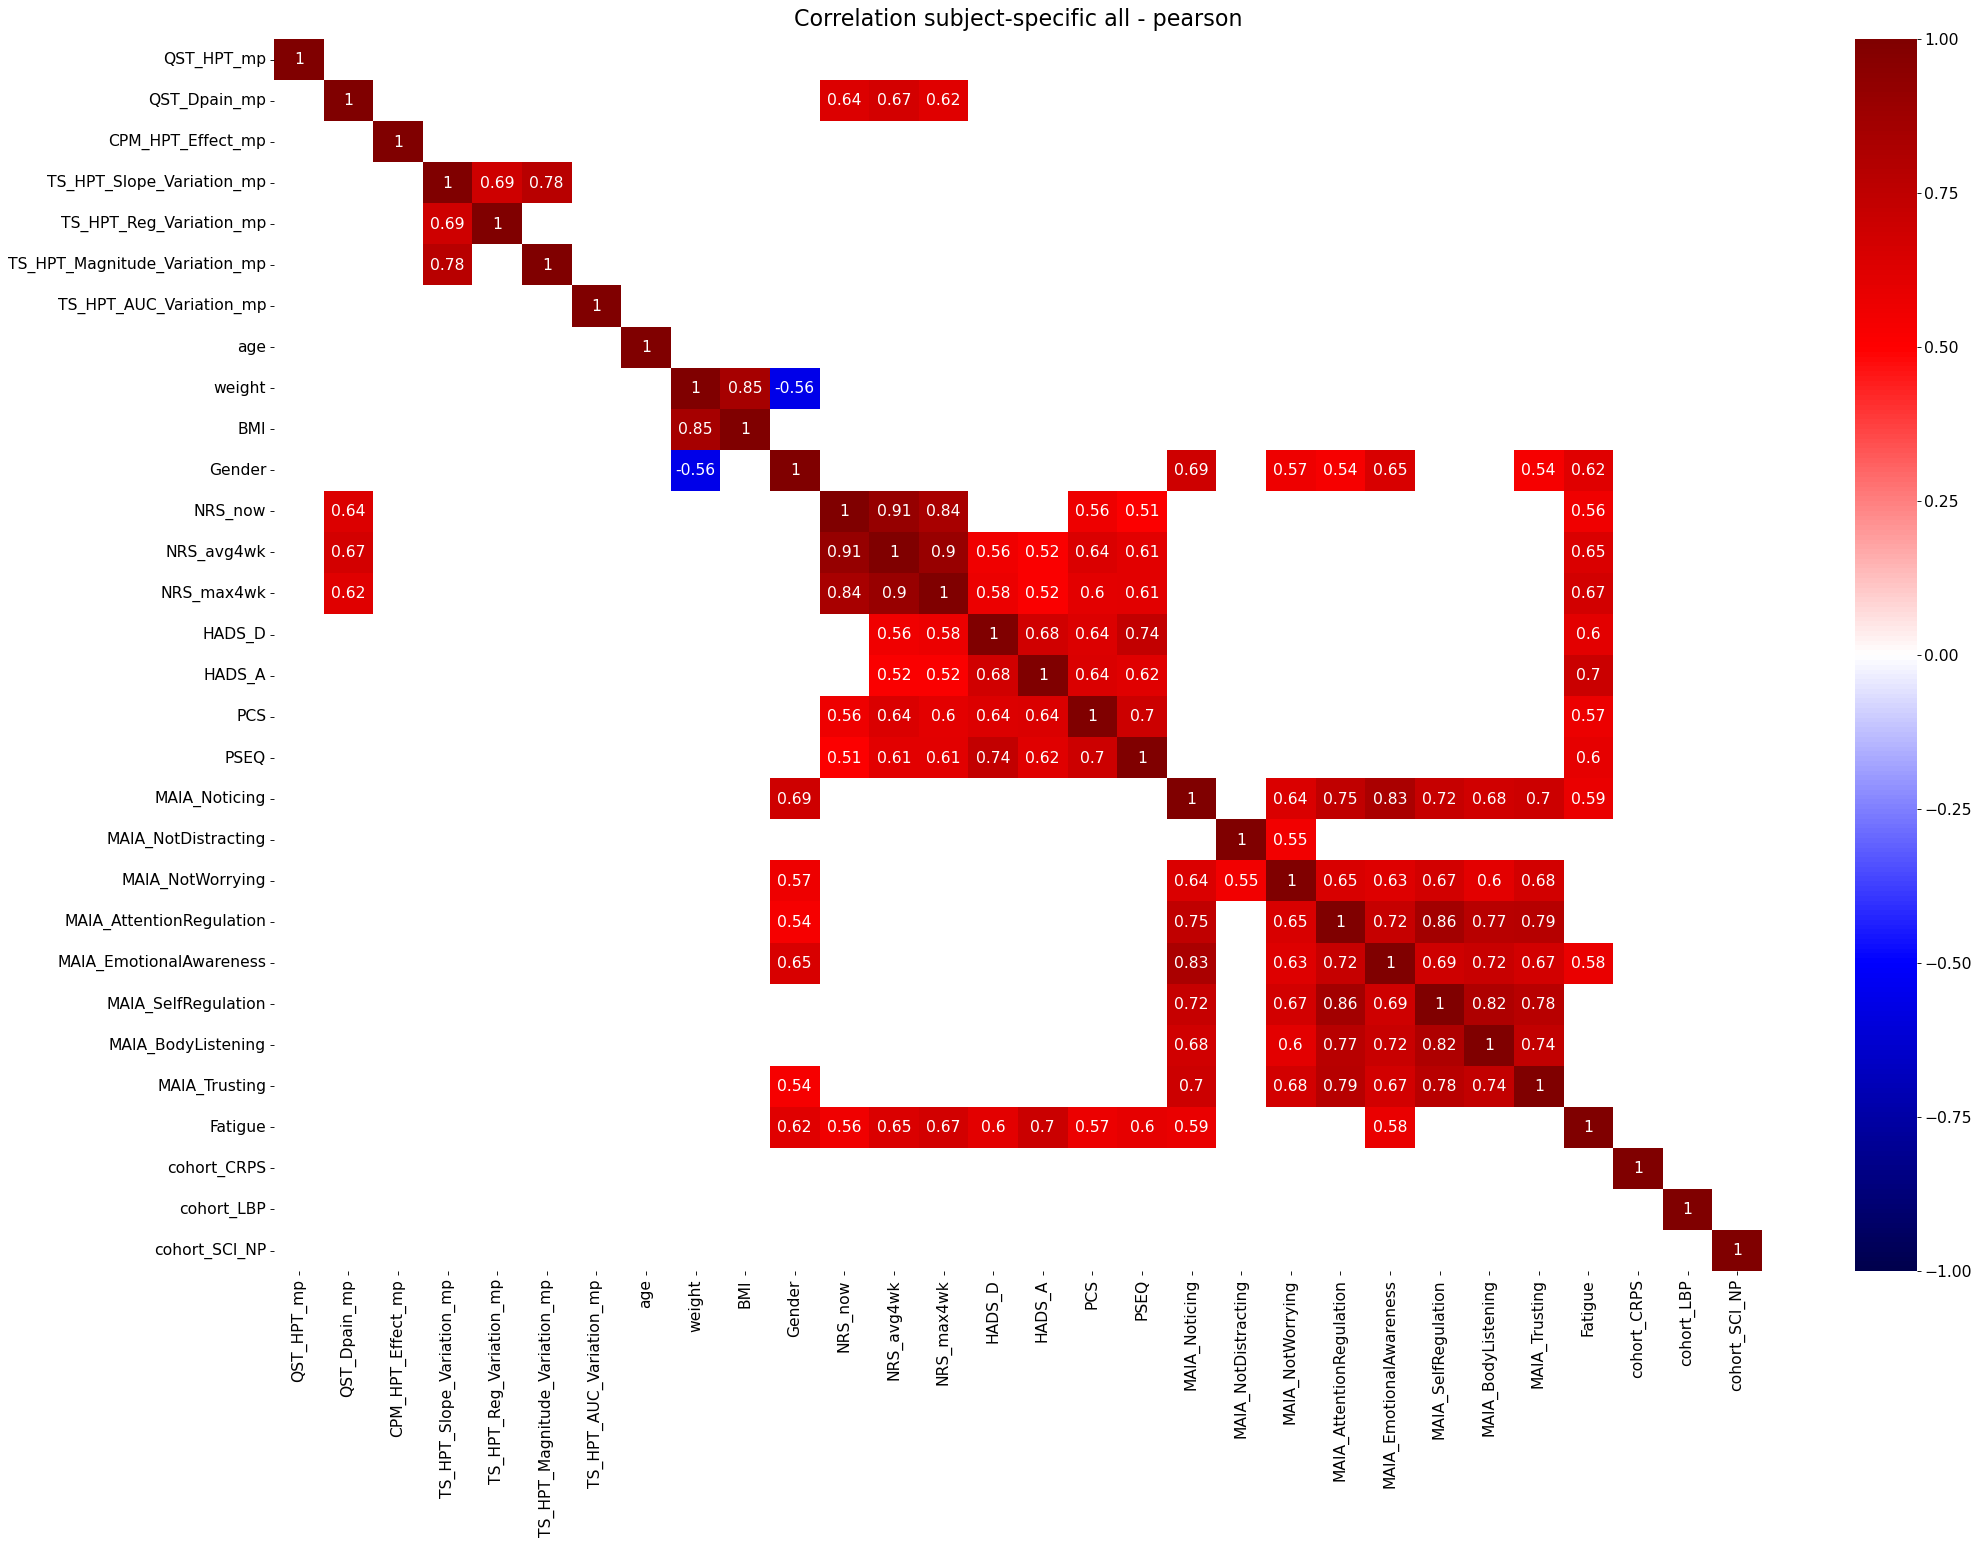

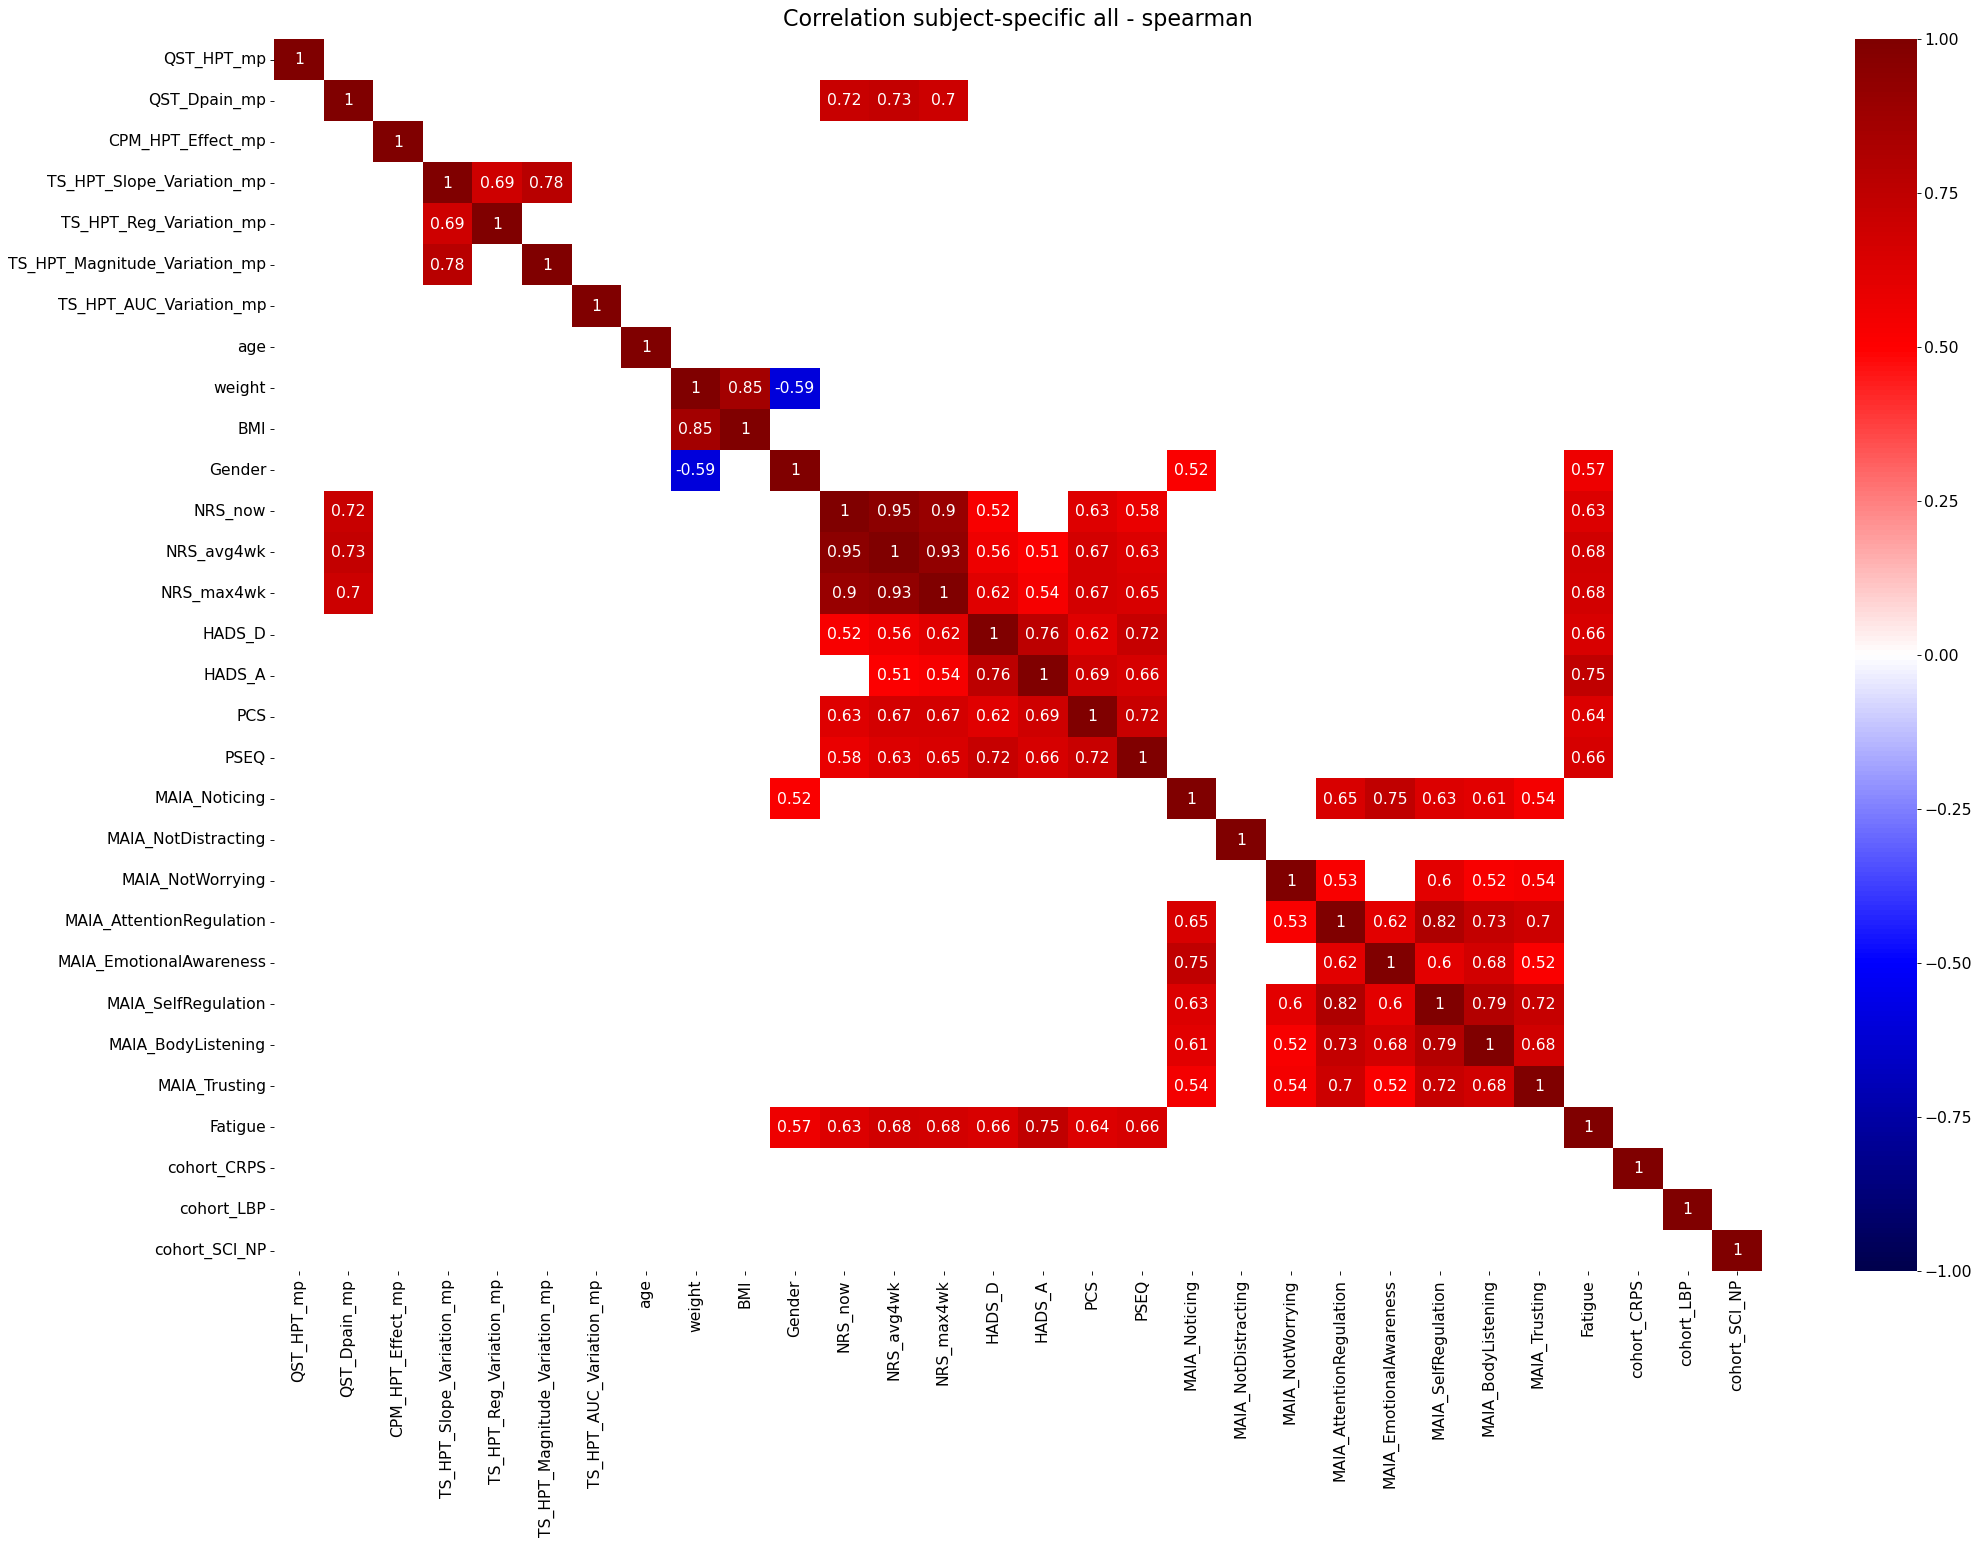

In [20]:
save=False
trials_subj = trials_subj.loc[:, (trials_subj != 0).any(axis=0)]
for corr_method in ["pearson", "spearman"]:
    plt.figure(figsize=(30,20))
    corr=trials_subj.corr(method=corr_method)
    matrix = np.triu(trials_subj.corr())
    mask=(corr>=0.5) | (corr <=-0.5)
    #heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap="seismic")
    heatmap = sns.heatmap(corr[mask], vmin=-1, vmax=1, annot=True, cmap="seismic")
    heatmap.set_title('Correlation subject-specific all - '+corr_method, fontdict={'fontsize':20}, pad=12)
    if save:
        plt.savefig(RESULTS_DIR_EDA + "Correlation/subject-specific all - "+corr_method, dpi=300)

# Variance Inflation Factor

In [21]:
#from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [22]:
## MANUAL ONE HOT ENCODED
def Preprocessing(ds, cols_cat):
    # preprocessing dataset
    for col in cols_cat:
        try:
            ds[col] = (ds[col]).str.upper()
        except:
            pass
        dummies = pd.get_dummies(ds[col], prefix=col)
        if ds[col].nunique() == 2: # handle nan, messi a zero
            dummies = dummies.drop(dummies.columns[0], axis=1)
        ds = pd.merge(ds, dummies, left_index=True, right_index=True)
        ds = ds.drop(col, axis=1)
    return ds

In [23]:
trials

id  Area  B  iTrial       SCH_var   SCH_iqr  \
id       Area B iTrial                                                      
CRPP_001 1    1 1       CRPP_001     1  1       1  9.913875e-08  0.000609   
                2       CRPP_001     1  1       2  1.896932e-07  0.000664   
                3       CRPP_001     1  1       3  2.012656e-08  0.000207   
                4       CRPP_001     1  1       4  8.280659e-08  0.000511   
                5       CRPP_001     1  1       5  2.048187e-07  0.000836   
...                          ...   ... ..     ...           ...       ...   
CRPP_135 2    2 16      CRPP_135     2  2      16  1.881871e-09  0.000035   
                17      CRPP_135     2  2      17  4.988407e-11  0.000012   
                18      CRPP_135     2  2      18  3.214282e-09  0.000039   
                19      CRPP_135     2  2      19  7.080697e-10  0.000035   
                20      CRPP_135     2  2      20  4.191231e-10  0.000027   

                         SCH_mad   SCH_rms  SCH_absmean       SCF_var  ...  \
id       Area B iTrial                                                 ...   
CRPP_001 1    1 1       0.000281  0.000784     0.000718  2.943668e-08  ...   
                2       0.000365  0.001347     0.001275  1.290564e-08  ...   
                3       0.000119  0.001765     0.001759  2.188395e-08  ...   
                4       0.000250  0.000814     0.000761  3.420908e-08  ...   
                5       0.000398  0.001237     0.001151  2.844384e-08  ...   
...                          ...       ...          ...           ...  ...   
CRPP_135 2    2 16      0.000032  0.000196     0.000191  3.325052e-09  ...   
                17      0.000006  0.000072     0.000071  7.753443e-08  ...   
                18      0.000039  0.000057     0.000009  2.748660e-07  ...   
                19      0.000023  0.000098     0.000094  7.801503e-09  ...   
                20      0.000016  0.000251     0.000250  1.181244e-08  ...   

                        EEG_alpha   EEG_beta  EEG_theta  EEG_gamma  \
id       Area B iTrial                                               
CRPP_001 1    1 1        9.880743  14.153608   6.961137   0.101196   
                2        7.086265   7.676675   3.817436   0.032640   
                3        8.045499   8.543812   8.126539   0.148750   
                4       24.360688  10.194991  15.345273   0.388893   
                5        8.177087  24.258615   4.097546   0.173685   
...                           ...        ...        ...        ...   
CRPP_135 2    2 16       3.631894   4.467131  20.453167   0.146703   
                17       6.162681   6.756320   5.119593   0.501653   
                18       5.122348  11.750664   6.944303   0.224558   
                19       2.350755   8.892655  10.387507   0.168946   
                20       3.629830   5.912861   4.739713   0.300492   

                        EEG_peak_frequency  EEG_peak_alpha_frequency  \
id       Area B iTrial                                                 
CRPP_001 1    1 1                        4                        12   
                2                       10                        10   
                3                        4                         9   
                4                        6                        10   
                5                       11                        11   
...                                    ...                       ...   
CRPP_135 2    2 16                       4                         8   
                17                       4                        10   
                18                       4                        10   
                19                       4                         9   
                20                       4                        10   

                        EEG_peak_beta_frequency  EEG_SampEn_01  \
id       Area B iTrial                                           
CRPP_001 1    1 1                

In [24]:
trials=trials.select_dtypes(include=['int64', 'float64'])
trials.dropna(inplace=True)
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = trials.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(trials.values, i) 
                          for i in range(len(trials.columns))] 
  
print(vif_data)

                     feature           VIF
0                       Area      6.919804
1                          B      9.930821
2                     iTrial      4.310461
3                    SCH_var     10.479658
4                    SCH_iqr    146.028301
5                    SCH_mad    267.692941
6                    SCH_rms    357.040826
7                SCH_absmean    168.349031
8                    SCF_var      7.078315
9                    SCF_iqr     93.517349
10                   SCF_mad    173.613691
11                   SCF_rms    214.331826
12               SCF_absmean    112.009074
13                       NRS      2.916108
14              EEG_kurtosis      9.128014
15                  EEG_skew      1.069758
16                  EEG_mean      1.076651
17                SCH_1D_min     14.751965
18                SCH_1D_max     77.231942
19               SCH_1D_mean      3.764688
20                SCH_1D_var     27.098364
21                SCF_1D_min      8.971648
22         